In [316]:
import librosa
from librosa import display
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.decomposition import PCA
import seaborn as sns
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
sns.set_style('whitegrid')

ImportError: No module named 'mpl_toolkits.mplot3d'

In [272]:
xp, fsp = librosa.load('./procon.wav')

In [14]:
ipd.Audio(xp, rate=fsp)

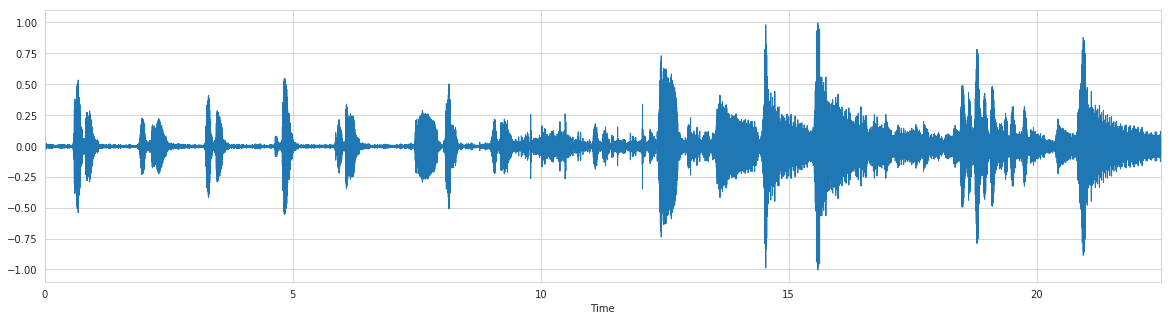

In [18]:
plt.figure(figsize=(20,5))
display.waveplot(xp, fsp)
plt.show()

In [71]:
frame_length=4096
hop_length=int(frame_length*0.5)

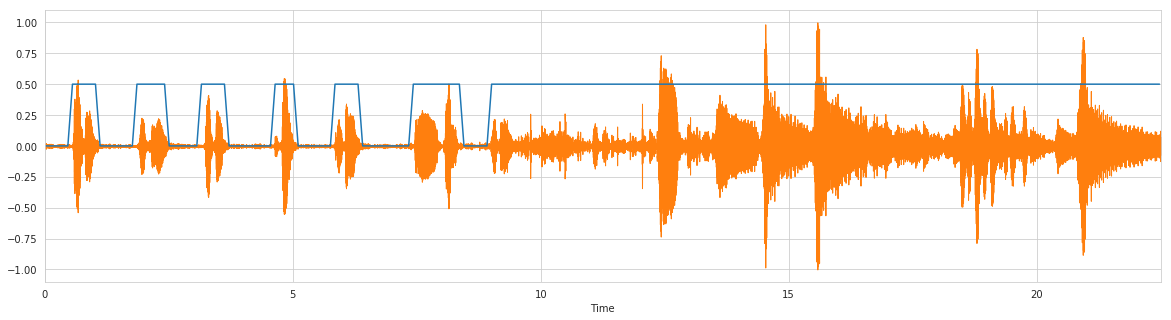

In [273]:
rmse = librosa.feature.rmse(xp,frame_length=frame_length,hop_length=hop_length,center=True)
mask = np.zeros_like(rmse)
mask[rmse>0.02] = 0.5
mask = mask[0].ravel()
t = librosa.frames_to_time(range(len(mask)),sr=fsp,hop_length=hop_length)
plt.figure(figsize=(20,5))
plt.plot(t,mask)
display.waveplot(xp, fsp)
plt.show()

In [274]:
samples = librosa.frames_to_samples(range(len(mask)),hop_length=hop_length)
samples_sil = np.where(mask < 0.2)[0]
samples_event = np.where(mask >= 0.2)[0]
sf = librosa.samples_to_frames(range(len(xp)),hop_length=hop_length)

In [275]:
@jit(nopython=True,parallel=True)
def framesinds2sampleinds(samples,samp2frame_array):
    inds = np.empty(0,np.int16)
    for ind in samples:
        inds = np.concatenate((inds,np.where(samp2frame_array == ind)[0].astype(np.int16)))
    return inds

In [279]:
samples_silence = np.array([],dtype=int)
for ind in samples_sil:
        samples_silence = np.concatenate([samples_silence,np.where(sf == ind)[0]])


In [280]:
samples_events = np.array([],dtype=int)
for ind in samples_event:
        samples_events = np.concatenate([samples_events,np.where(sf == ind)[0]])

In [281]:
xp_event = xp[samples_events]
xp_sil = xp[samples_silence]

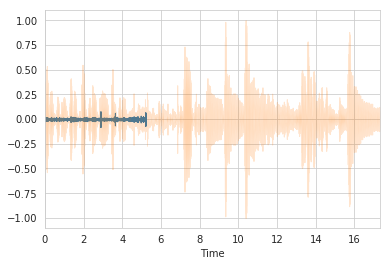

In [282]:
librosa.display.waveplot(xp_sil)
librosa.display.waveplot(xp_event,alpha=0.2)

In [297]:
ipd.Audio(xp_event,rate=fsp)

In [298]:
ipd.Audio(xp_event[xp_event.size//2:],rate=fsp)

In [292]:
mfcc_event = librosa.feature.mfcc(xp_event, fsp, n_fft=4096, hop_length = 1024)
mfcc_scaled_event = scale(mfcc_event,axis=1)

In [293]:
mfcc_sil = librosa.feature.mfcc(xp_sil, fsp, n_fft=4096, hop_length = 1024)
mfcc_scaled_sil = scale(mfcc_sil,axis=1)

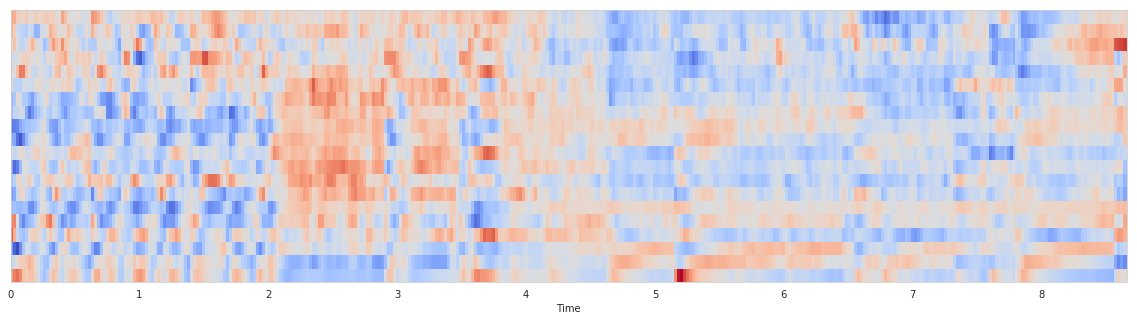

In [294]:
plt.figure(figsize=(20,5))
display.specshow(mfcc_scaled_event, sr=fsp, cmap='coolwarm',x_axis='time')
plt.show()

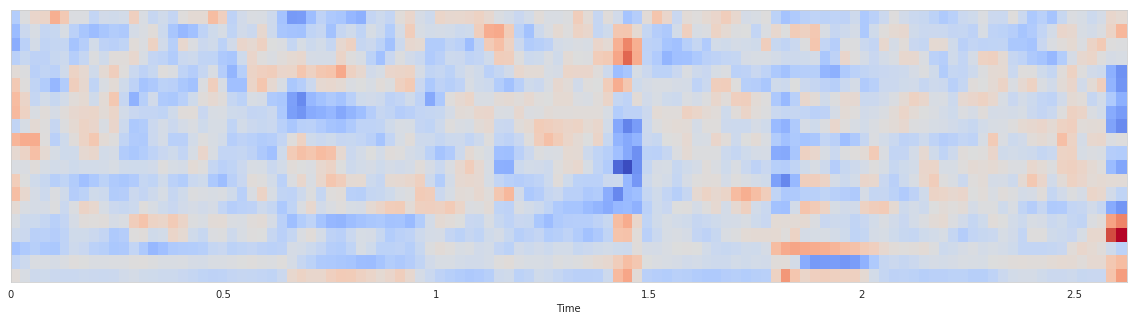

In [295]:
plt.figure(figsize=(20,5))
display.specshow(mfcc_scaled_sil, sr=fsp, cmap='coolwarm',x_axis='time')
plt.show()

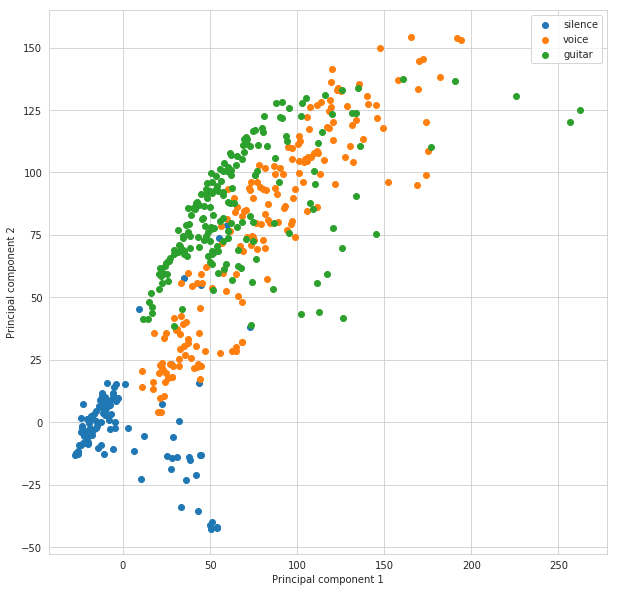

In [314]:
df = pd.DataFrame(mfcc_sil.T)
df2 = pd.DataFrame(mfcc_event.T)
pca = PCA(n_components=3)
newdf = pd.DataFrame(pca.fit_transform(df))
newdf2 = pd.DataFrame(pca.transform(df2))
plt.figure(figsize=(10,10))
plt.scatter(newdf[0],newdf[1])
plt.scatter(newdf2[0].iloc[:newdf2.shape[0]//2],newdf2[1].iloc[:newdf2.shape[0]//2])
plt.scatter(newdf2[0].iloc[newdf2.shape[0]//2:],newdf2[1].iloc[newdf2.shape[0]//2:])
plt.legend(['silence','voice','guitar'])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()